# Detección de fraude


In [9]:
### Librerias e importaciones

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de pandas para mostrar más columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Librerías importadas correctamente")

Librerías importadas correctamente


## Fase 1: Exploración de Datos (EDA)

### 1. Carga y Exploración Inicial

In [10]:
df = pd.read_csv('creditcard.csv')

print("=" * 60)
print("INFORMACIÓN BÁSICA DEL DATASET")
print("=" * 60)
print(f"\nDimensiones del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]:,}")
print(f"Número de columnas: {df.shape[1]}")

INFORMACIÓN BÁSICA DEL DATASET

Dimensiones del dataset: (284807, 31)
Número de filas: 284,807
Número de columnas: 31


In [11]:
# Información sobre tipos de datos y valores faltantes
print("=" * 60)
print("INFORMACIÓN DE COLUMNAS Y TIPOS DE DATOS")
print("=" * 60)
print(df.info())

print("\n" + "=" * 60)
print("VALORES FALTANTES")
print("=" * 60)
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Valores Faltantes': missing_values,
    'Porcentaje': missing_percent
})
missing_df = missing_df[missing_df['Valores Faltantes'] > 0]
if len(missing_df) > 0:
    print(missing_df)
else:
    print("✓ No hay valores faltantes en el dataset")

INFORMACIÓN DE COLUMNAS Y TIPOS DE DATOS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20    

In [12]:
# Estadísticas descriptivas por clase
print("=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS POR CLASE")
print("=" * 60)
print("\nEstadísticas de Amount por clase:")
print(df.groupby('Class')['Amount'].describe())

print("\nEstadísticas de Time por clase:")
print(df.groupby('Class')['Time'].describe())

ESTADÍSTICAS DESCRIPTIVAS POR CLASE

Estadísticas de Amount por clase:
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87

Estadísticas de Time por clase:
          count          mean           std    min      25%      50%  \
Class                                                                  
0      284315.0  94838.202258  47484.015786    0.0  54230.0  84711.0   
1         492.0  80746.806911  47835.365138  406.0  41241.5  75568.5   

            75%       max  
Class                      
0      139333.0  172792.0  
1      128483.0  170348.0  


### 2. Análisis de Distribución

In [13]:
# Distribución de la variable objetivo (Class)
print("=" * 60)
print("DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (CLASS)")
print("=" * 60)
class_distribution = df['Class'].value_counts()
class_percentage = df['Class'].value_counts(normalize=True) * 100

dist_df = pd.DataFrame({
    'Cantidad': class_distribution,
    'Porcentaje': class_percentage
})
dist_df.index = ['Normal (0)', 'Fraude (1)']
print(dist_df)

print(f"\nTotal de transacciones: {len(df):,}")
print(f"Transacciones normales: {class_distribution[0]:,} ({class_percentage[0]:.2f}%)")
print(f"Transacciones fraudulentas: {class_distribution[1]:,} ({class_percentage[1]:.2f}%)")
print(f"\n⚠️ DESBALANCE CRÍTICO: Ratio de {class_distribution[0]/class_distribution[1]:.1f}:1")

DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (CLASS)
            Cantidad  Porcentaje
Normal (0)    284315   99.827251
Fraude (1)       492    0.172749

Total de transacciones: 284,807
Transacciones normales: 284,315 (99.83%)
Transacciones fraudulentas: 492 (0.17%)

⚠️ DESBALANCE CRÍTICO: Ratio de 577.9:1


### 3. Visualizaciones Clave

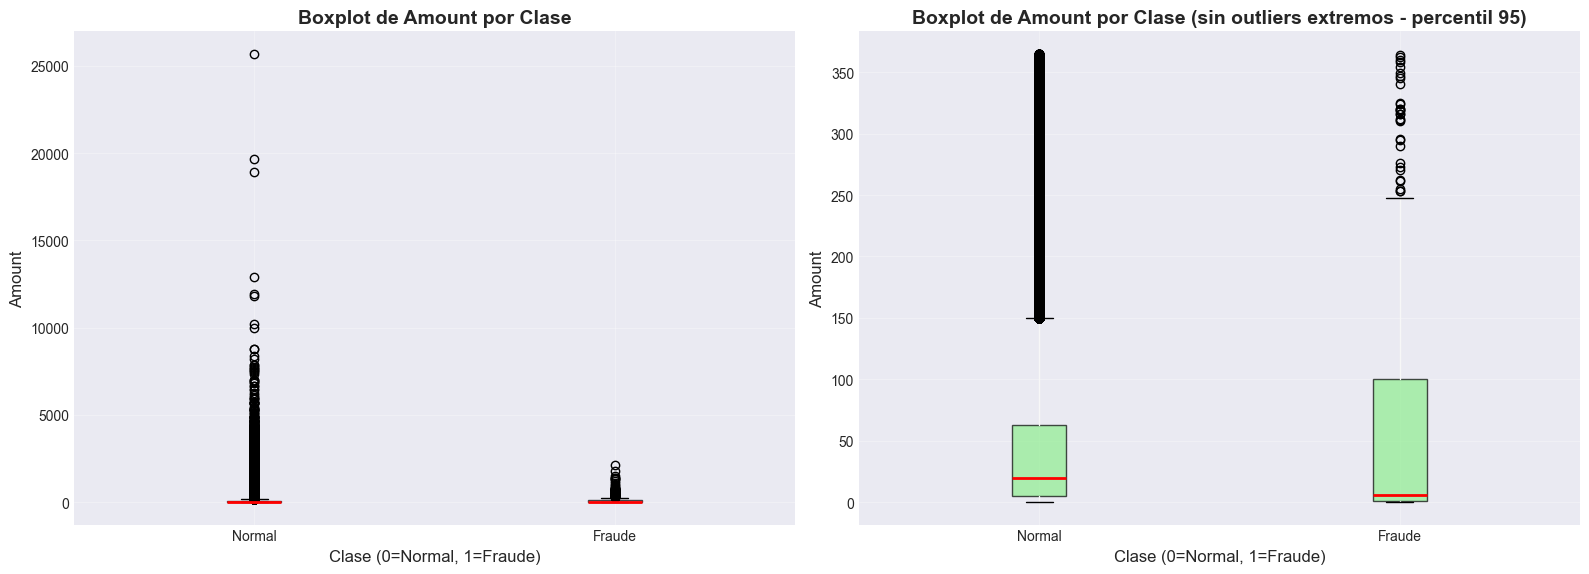

In [14]:
# Boxplots comparativos de Amount por clase
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot estándar
df.boxplot(column='Amount', by='Class', ax=axes[0], 
           patch_artist=True, 
           boxprops=dict(facecolor='lightblue', alpha=0.7),
           medianprops=dict(color='red', linewidth=2))
axes[0].set_title('Boxplot de Amount por Clase', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase (0=Normal, 1=Fraude)', fontsize=12)
axes[0].set_ylabel('Amount', fontsize=12)
axes[0].set_xticklabels(['Normal', 'Fraude'])
axes[0].grid(True, alpha=0.3)

# Boxplot sin outliers extremos para mejor visualización
df_filtered = df[df['Amount'] <= df['Amount'].quantile(0.95)]
df_filtered.boxplot(column='Amount', by='Class', ax=axes[1],
                    patch_artist=True,
                    boxprops=dict(facecolor='lightgreen', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
axes[1].set_title('Boxplot de Amount por Clase (sin outliers extremos - percentil 95)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Clase (0=Normal, 1=Fraude)', fontsize=12)
axes[1].set_ylabel('Amount', fontsize=12)
axes[1].set_xticklabels(['Normal', 'Fraude'])
axes[1].grid(True, alpha=0.3)

plt.suptitle('')  # Eliminar título automático
plt.tight_layout()
plt.show()

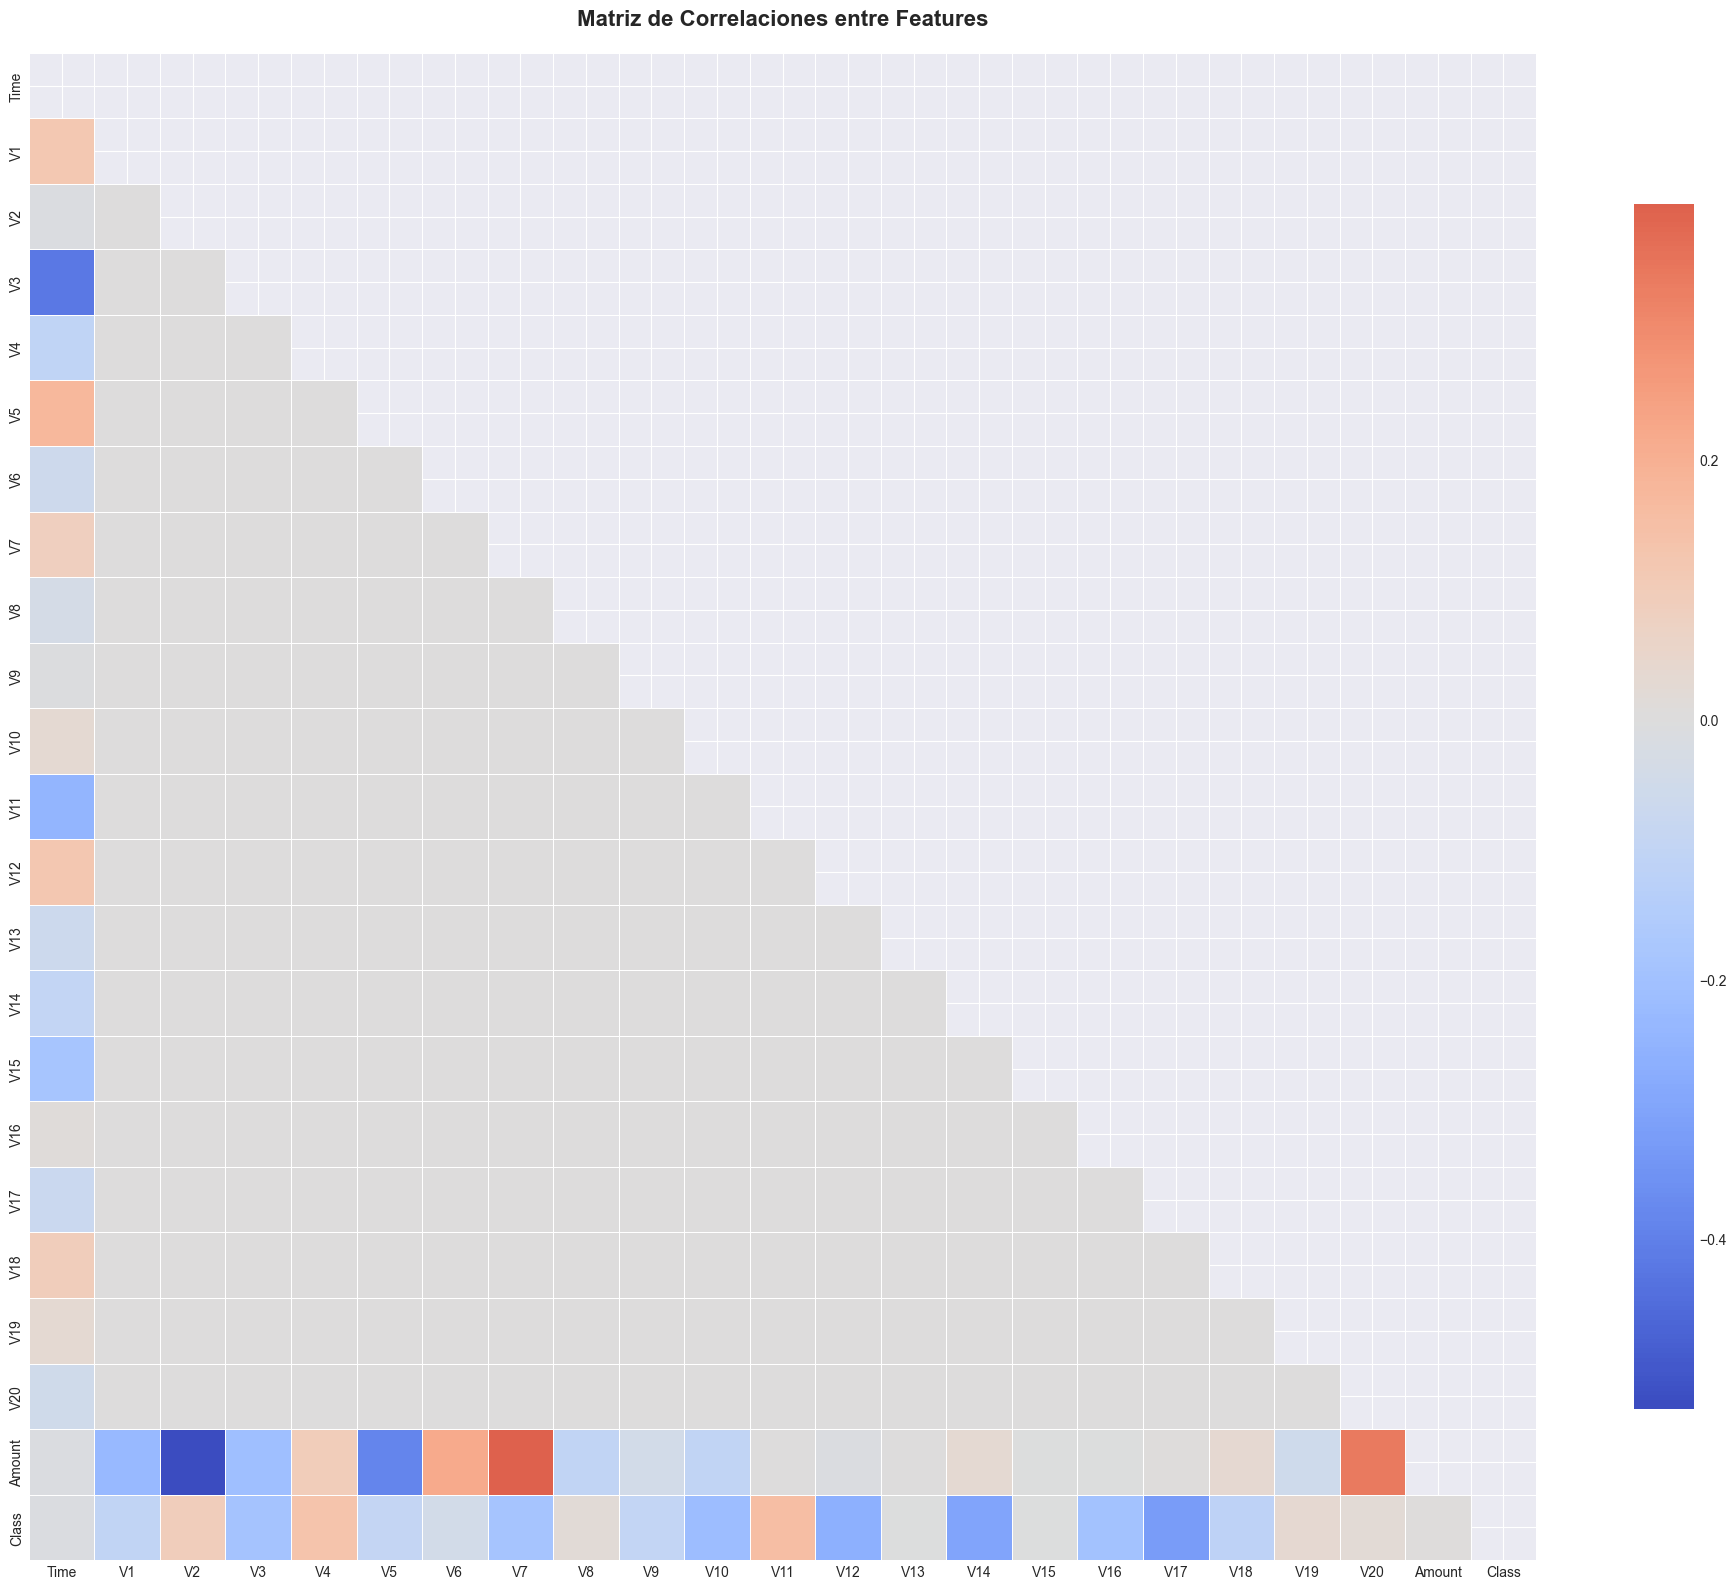

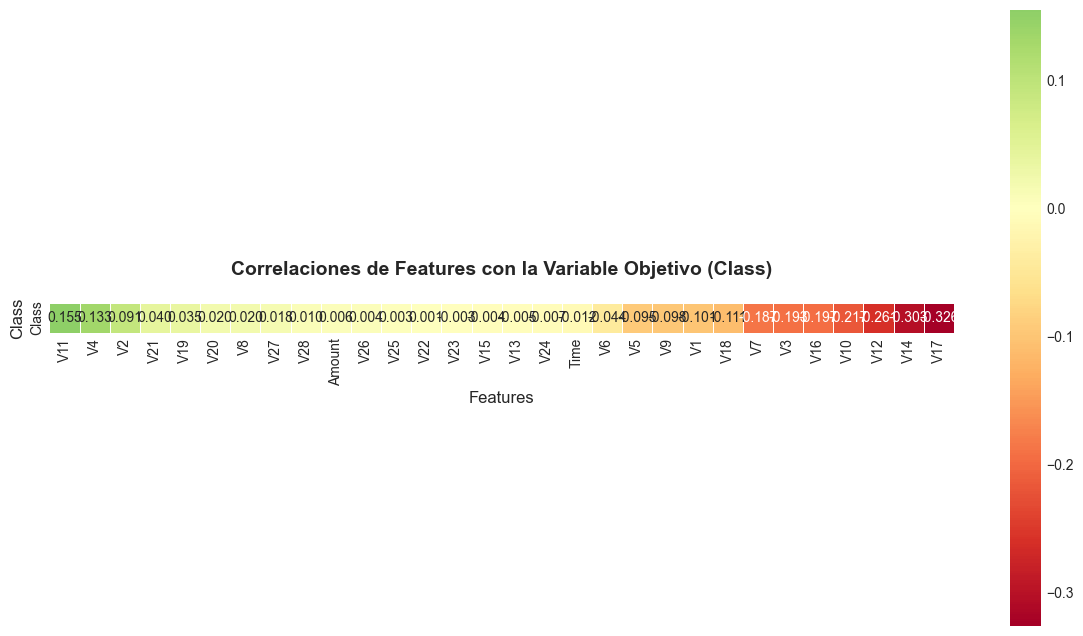

In [15]:
# Heatmap de correlaciones (tomo muestra para mejor visualización)
# Seleccionar un subconjunto de features más importantes para el heatmap
correlation_cols = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                    'Amount', 'Class']

# Calcular matriz de correlación
corr_matrix = df[correlation_cols].corr()

# Crear heatmap
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Máscara para mostrar solo triángulo inferior
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Matriz de Correlaciones entre Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Heatmap enfocado en correlaciones con la variable objetivo
plt.figure(figsize=(12, 8))
class_corr = df.corr()['Class'].sort_values(ascending=False)
class_corr = class_corr.drop('Class')  # Eliminar autocorrelación
sns.heatmap(class_corr.to_frame().T, annot=True, cmap='RdYlGn', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.3f')
plt.title('Correlaciones de Features con la Variable Objetivo (Class)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Class', fontsize=12)
plt.tight_layout()
plt.show()

### Validación del preprocesador reutilizable (Fase 1 - Producción)

Se usa el módulo `src/preprocessing.py` para asegurar que el mismo pipeline (log1p en Amount + RobustScaler) se aplica en entrenamiento e inferencia. Se valida que las predicciones no cambian y se guarda el preprocesador con joblib.

In [17]:
#  originalmente el robust scaler se ajustaba con TODO el dataset antes del split; en producción
# debe ajustarse solo con train. Este módulo hace fit en train y transform en test/inferencia.
from src.preprocessing import FraudPreprocessor, FEATURE_COLUMNS, API_FEATURE_SPEC
import joblib
import os
TEST_SIZE = 0.20
RANDOM_STATE = 42
# Definir la variable y (target) antes del split
y = df["Class"]

# Mismo split que el notebook pero sobre datos crudos (sin escalar)
X_raw = df.drop("Class", axis=1)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

preprocessor = FraudPreprocessor()
preprocessor.fit(X_train_raw)
X_test_from_module = preprocessor.transform(X_test_raw)

# Comprobar contra el mismo pipeline manual (log1p + RobustScaler fit solo en train)
X_train_manual = X_train_raw.copy()
X_train_manual["Amount"] = np.log1p(X_train_manual["Amount"])
X_test_manual = X_test_raw.copy()
X_test_manual["Amount"] = np.log1p(X_test_manual["Amount"])
from sklearn.preprocessing import RobustScaler
scaler_manual = RobustScaler()
scaler_manual.fit(X_train_manual)
X_test_expected = scaler_manual.transform(X_test_manual)
assert np.allclose(X_test_from_module, X_test_expected, rtol=1e-9, atol=1e-9), (
    "Preprocesador no coincide con pipeline log1p + RobustScaler(fit en train)"
)
print("Validación OK: el módulo src.preprocessing reproduce el pipeline (log1p + RobustScaler fit en train).")

# Guardar preprocesador para la API (se usará después del split para crear X_train/X_test correctos)
os.makedirs("models", exist_ok=True)
os.makedirs("models/v1", exist_ok=True)
joblib.dump(preprocessor, "models/v1/preprocessor.joblib")
print("Preprocesador guardado en models/v1/preprocessor.joblib")

# Documentación de columnas para la API
print("\nColumnas requeridas para /predict:", FEATURE_COLUMNS)

Validación OK: el módulo src.preprocessing reproduce el pipeline (log1p + RobustScaler fit en train).
Preprocesador guardado en models/v1/preprocessor.joblib

Columnas requeridas para /predict: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


### Resumen de la Fase 1: Exploración de Datos

1. **Desbalance crítico**: El dataset tiene un desbalance extremo con solo 0.17% de transacciones fraudulentas
2. **Sin valores faltantes**: El dataset está completo y limpio
3. **Features anonimizadas**: Las features V1-V28 son resultado de PCA, protegiendo la privacidad
4. **Distribución de Amount**: Las transacciones fraudulentas pueden tener diferentes patrones de monto
5. **Correlaciones**: Varias features muestran correlaciones significativas con la variable objetivo


## Fase 2: Preprocesamiento de Datos

### 1. Preparación de Features

In [18]:
# Separar features (X) y target (y)
print("=" * 60)
print("PREPARACIÓN DE FEATURES Y TARGET")
print("=" * 60)

# Separar las variables
y = df['Class']
X = df.drop('Class', axis=1)

print(f"\nDimensiones de X (features): {X.shape}")
print(f"Dimensiones de y (target): {y.shape}")


PREPARACIÓN DE FEATURES Y TARGET

Dimensiones de X (features): (284807, 30)
Dimensiones de y (target): (284807,)


ANÁLISIS DE DISTRIBUCIONES: Time y Amount


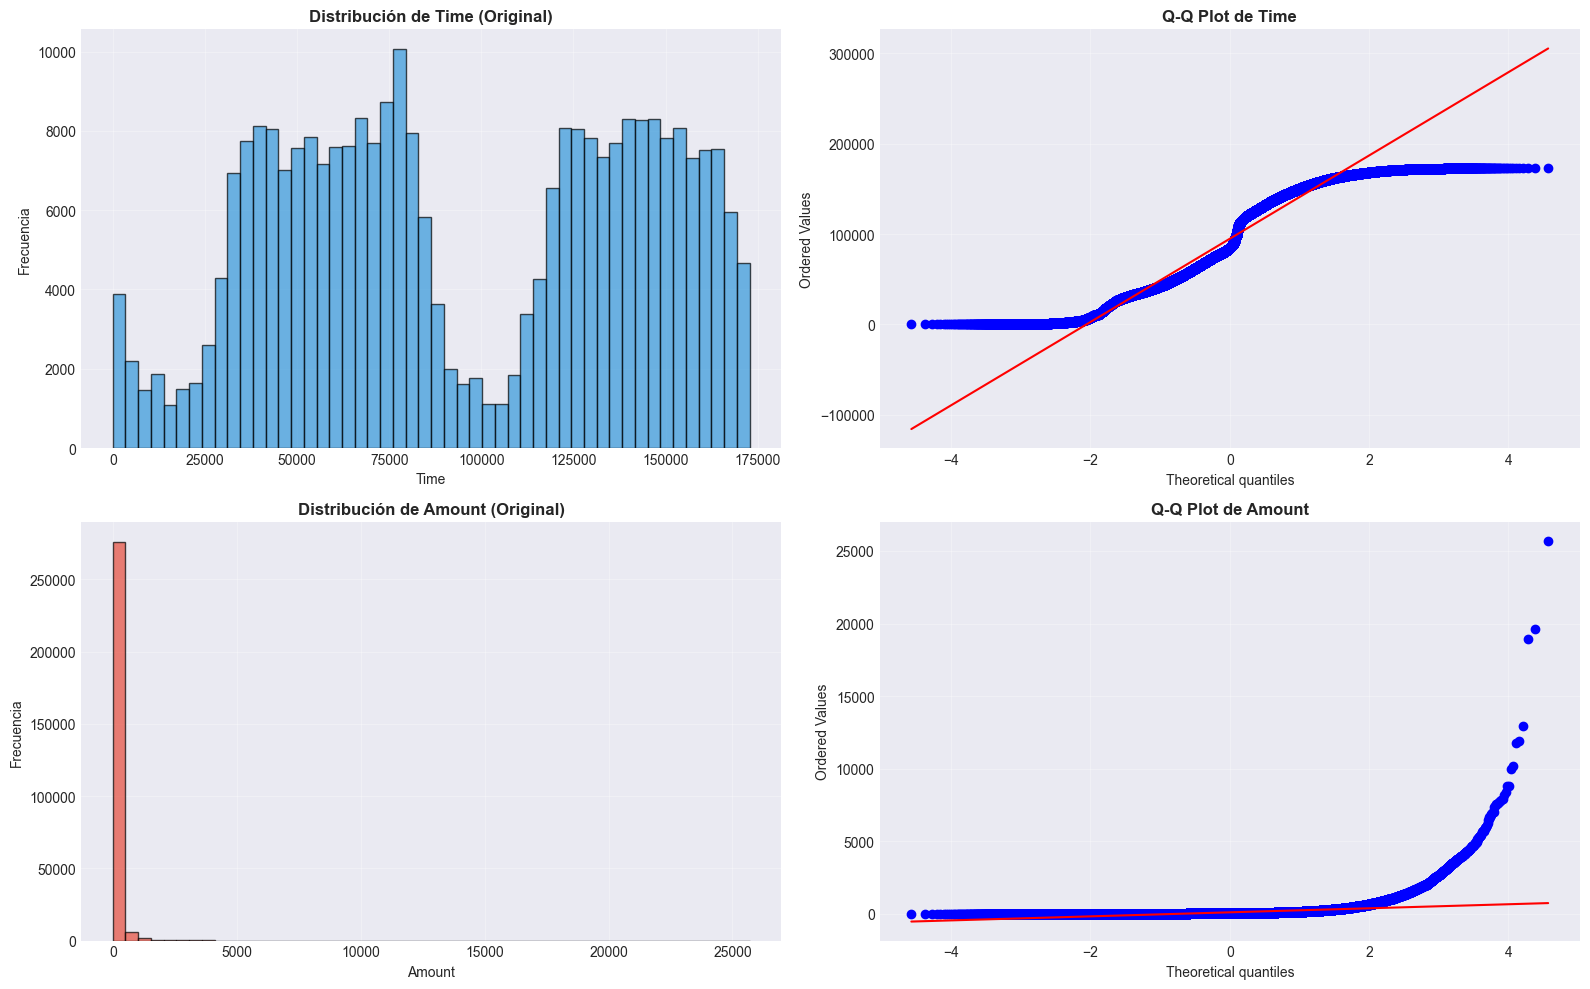


Asimetría (Skewness):
Time: -0.0356
Amount: 16.9776

(Valores cercanos a 0 indican distribución normal)
(Valores > 1 o < -1 indican distribución asimétrica)


In [19]:
# Análisis de las distribuciones de Time y Amount para decidir transformaciones
print("=" * 60)
print("ANÁLISIS DE DISTRIBUCIONES: Time y Amount")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distribución de la variable Time: histograma para observar su forma general
axes[0, 0].hist(X['Time'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribución de Time (Original)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time', fontsize=10)
axes[0, 0].set_ylabel('Frecuencia', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Quantile-Quantile plot de Time para comparar la distribución empírica con una normal teórica
# El objetivo es decidir si es necesario aplicar alguna transformación 
# (por ejemplo, escalado, normalización) antes de usarlo en modelos que asumen normalidad, o que tienen mejor desempeño con variables normales.
# En el Q-Q plot, si los puntos caen cerca de la recta, los datos siguen una distribución normal.
from scipy import stats
stats.probplot(X['Time'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot de Time', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Distribución de la variable Amount: histograma para observar su forma general
axes[1, 0].hist(X['Amount'], bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribución de Amount (Original)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Amount', fontsize=10)
axes[1, 0].set_ylabel('Frecuencia', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Q-Q plot de Amount: compara la distribución empírica de Amount con la normal.
stats.probplot(X['Amount'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot de Amount', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de asimetría (skewness) para medir qué tan simétrica es la distribución de las variables
# Valores cercanos a 0 indican simetría similar a la normal, valores altos (positivos o negativos) indican fuerte asimetría
from scipy.stats import skew
print(f"\nAsimetría (Skewness):")
print(f"Time: {skew(X['Time']):.4f}")
print(f"Amount: {skew(X['Amount']):.4f}")
print(f"\n(Valores cercanos a 0 indican distribución normal)")
print(f"(Valores > 1 o < -1 indican distribución asimétrica)")

TRANSFORMACIÓN DE FEATURES


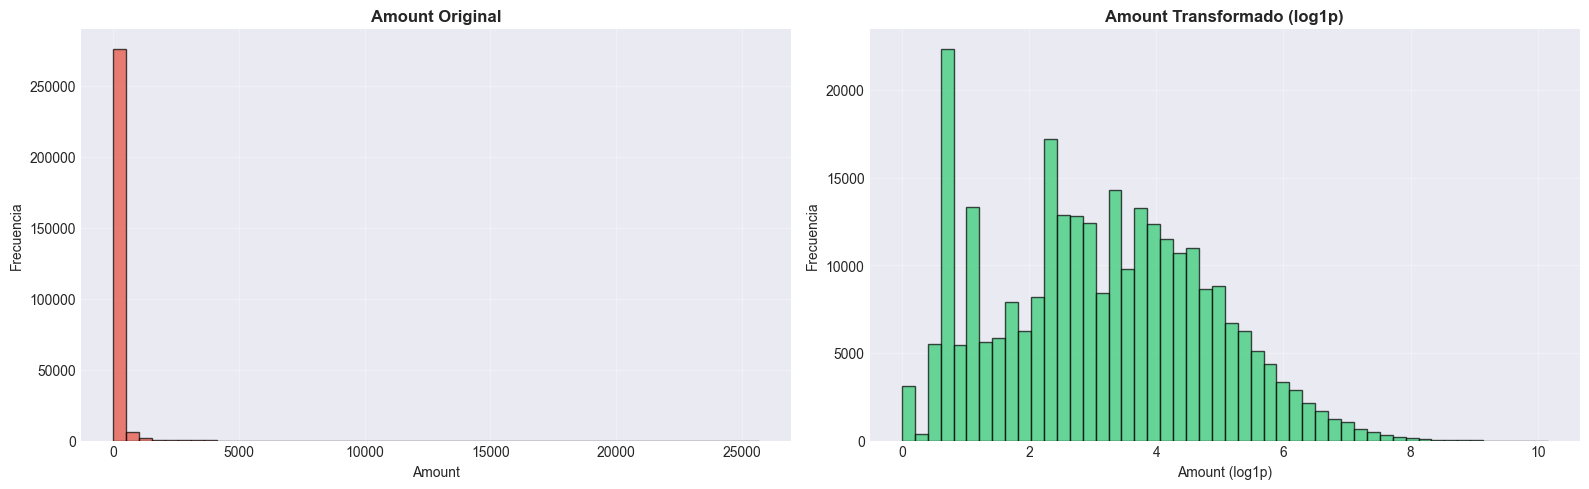


Asimetría antes de transformación:
Amount original: 16.9776

Asimetría después de transformación logarítmica:
Amount log1p: 0.1627

✓ Transformación aplicada: Amount -> log1p(Amount)
✓ Dimensiones finales de X_processed: (284807, 30)


In [20]:
# Aplicar transformación logarítmica a Amount (para reducir asimetría)
# Agregar 1 para evitar log(0) en caso de valores cero
print("=" * 60)
print("TRANSFORMACIÓN DE FEATURES")
print("=" * 60)

# Crear una copia de X para trabajar
X_processed = X.copy()

# Transformación logarítmica de Amount
X_processed['Amount_log'] = np.log1p(X_processed['Amount'])  # log1p = log(1+x) para evitar log(0)

# Visualizar la transformación
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(X['Amount'], bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0].set_title('Amount Original', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Amount', fontsize=10)
axes[0].set_ylabel('Frecuencia', fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].hist(X_processed['Amount_log'], bins=50, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1].set_title('Amount Transformado (log1p)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Amount (log1p)', fontsize=10)
axes[1].set_ylabel('Frecuencia', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAsimetría antes de transformación:")
print(f"Amount original: {skew(X['Amount']):.4f}")
print(f"\nAsimetría después de transformación logarítmica:")
print(f"Amount log1p: {skew(X_processed['Amount_log']):.4f}")

# Decidir si mantener Amount original o transformado
# Por ahora, mantenemos ambos para comparar, pero usaremos el transformado
X_processed = X_processed.drop('Amount', axis=1)  # Eliminar Amount original
X_processed = X_processed.rename(columns={'Amount_log': 'Amount'})  # Renombrar

print(f"\n✓ Transformación aplicada: Amount -> log1p(Amount)")
print(f"✓ Dimensiones finales de X_processed: {X_processed.shape}")

ESCALADO DE FEATURES

Rango de valores antes del escalado:
Time - Min: 0.00, Max: 172792.00, Std: 47488.15
Amount - Min: 0.0000, Max: 10.1539, Std: 1.6566

✓ Escalado completado usando RobustScaler
✓ Dimensiones de X_scaled: (284807, 30)

Rango de valores después del escalado:
Time - Min: -0.9950, Max: 1.0350, Std: 0.5579
Amount - Min: -1.2685, Max: 2.8395, Std: 0.6702


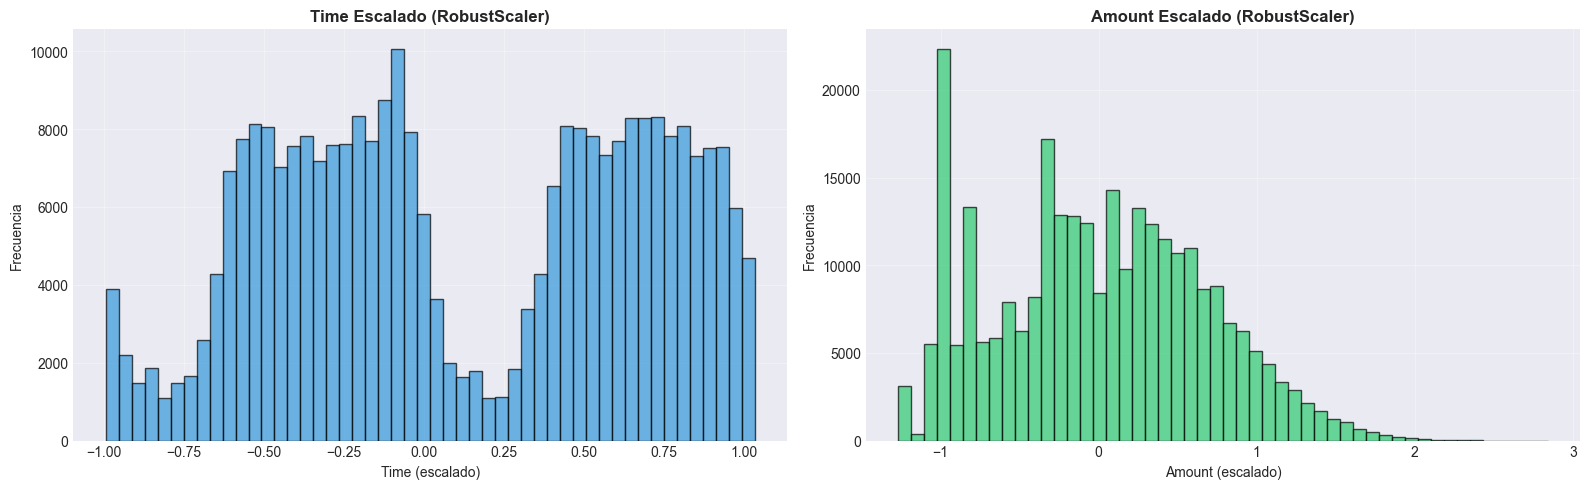

In [21]:
# Escalar Time y Amount
# Las features V1-V28 ya están escaladas (resultado de PCA), pero Time y Amount necesitan escalado
print("=" * 60)
print("ESCALADO DE FEATURES")
print("=" * 60)

# Verificar el rango de valores antes del escalado
print("\nRango de valores antes del escalado:")
print(f"Time - Min: {X_processed['Time'].min():.2f}, Max: {X_processed['Time'].max():.2f}, Std: {X_processed['Time'].std():.2f}")
print(f"Amount - Min: {X_processed['Amount'].min():.4f}, Max: {X_processed['Amount'].max():.4f}, Std: {X_processed['Amount'].std():.4f}")

# Usar RobustScaler para ser más robusto a outliers (mejor que StandardScaler para datos con outliers)
from sklearn.preprocessing import RobustScaler

# Crear el escalador
scaler = RobustScaler()

# Escalar todas las features (incluyendo Time y Amount)
# Las features V1-V28 también se escalarán aunque ya estén escaladas, pero esto asegura consistencia
X_scaled = scaler.fit_transform(X_processed)

# Convertir de vuelta a DataFrame manteniendo los nombres de columnas
X_scaled = pd.DataFrame(X_scaled, columns=X_processed.columns, index=X_processed.index)

print("\n✓ Escalado completado usando RobustScaler")
print(f"✓ Dimensiones de X_scaled: {X_scaled.shape}")

# Verificar el rango de valores después del escalado
print("\nRango de valores después del escalado:")
print(f"Time - Min: {X_scaled['Time'].min():.4f}, Max: {X_scaled['Time'].max():.4f}, Std: {X_scaled['Time'].std():.4f}")
print(f"Amount - Min: {X_scaled['Amount'].min():.4f}, Max: {X_scaled['Amount'].max():.4f}, Std: {X_scaled['Amount'].std():.4f}")

# Visualizar la distribución después del escalado
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(X_scaled['Time'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].set_title('Time Escalado (RobustScaler)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time (escalado)', fontsize=10)
axes[0].set_ylabel('Frecuencia', fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].hist(X_scaled['Amount'], bins=50, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1].set_title('Amount Escalado (RobustScaler)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Amount (escalado)', fontsize=10)
axes[1].set_ylabel('Frecuencia', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2. División de Datos (Train/Test Split)

División de los datos en conjunto de entrenamiento y de prueba para poder evaluar el modelo. Uso de **estratificación** para mantener la misma proporción de clases (normal/fraude) en ambos conjuntos, si no se usara podrían quedar casi todos los fraudes en train o en test

In [23]:
# Proporción para test (20%); el resto es train (80%)
TEST_SIZE = 0.20

# Semilla fija para reproducibilidad: mismos train/test en cada ejecución
RANDOM_STATE = 42

# División estratificada: X_scaled e y deben estar alineados por índice
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y  # Mantiene la proporción de Class en train y test
)

print("=" * 60)
print("DIVISIÓN TRAIN / TEST")
print("=" * 60)
print(f"\nProporción usada: {(1-TEST_SIZE)*100:.0f}% train, {TEST_SIZE*100:.0f}% test")
print(f"random_state={RANDOM_STATE} (reproducibilidad)")
print(f"stratify=y (misma proporción de clases en train y test)")

DIVISIÓN TRAIN / TEST

Proporción usada: 80% train, 20% test
random_state=42 (reproducibilidad)
stratify=y (misma proporción de clases en train y test)


In [24]:
# Verificar tamaños y proporción de clases en cada conjunto
print("Tamaños:")
print(f"  X_train: {X_train.shape[0]:,} filas, {X_train.shape[1]} columnas")
print(f"  X_test:  {X_test.shape[0]:,} filas, {X_test.shape[1]} columnas")

print("\nDistribución de la clase (Class) en cada conjunto:")
print("\n  TRAIN:")
print(y_train.value_counts().to_string())
print(f"  Fraude en train: {y_train.sum():,} ({100*y_train.mean():.2f}%)")

print("\n  TEST:")
print(y_test.value_counts().to_string())
print(f"  Fraude en test:  {y_test.sum():,} ({100*y_test.mean():.2f}%)")


Tamaños:
  X_train: 227,845 filas, 30 columnas
  X_test:  56,962 filas, 30 columnas

Distribución de la clase (Class) en cada conjunto:

  TRAIN:
Class
0    227451
1       394
  Fraude en train: 394 (0.17%)

  TEST:
Class
0    56864
1       98
  Fraude en test:  98 (0.17%)


In [ ]:
#  Necesitamos que el scaler se ajuste SOLO con train, para evitar data leakage.
# Usamos el preprocesador guardado en la celda de validación (fit en X_train_raw).

from src.preprocessing import FraudPreprocessor, FEATURE_COLUMNS
import joblib

preprocessor = joblib.load("models/v1/preprocessor.joblib")

# Redefinir X_train y X_test con el preprocesador correcto
# Nota: X_train_raw y X_test_raw vienen de la celda de validación (mismo split, datos crudos)
X_train = pd.DataFrame(preprocessor.transform(X_train_raw), columns=FEATURE_COLUMNS)
X_test = pd.DataFrame(preprocessor.transform(X_test_raw), columns=FEATURE_COLUMNS)

print("✓ X_train y X_test redefinidos con preprocesador 'solo train' (sin data leakage)")
print(f"  X_train: {X_train.shape}")
print(f"  X_test:  {X_test.shape}")

✓ X_train y X_test redefinidos con preprocesador 'solo train' (sin data leakage)
  X_train: (227845, 30)
  X_test:  (56962, 30)


### 3. Manejo del desbalance

Como el dataset tiene un porcentaje muy bajo de fraudes, si no se balanceara los modelos tebderian a predecir siempre "normal" . Evaluo dos técnicas:

- **SMOTE (Synthetic Minority Oversampling)**: genera ejemplos sintéticos de la clase minoritaria (fraude), aumenta el tamaño del train  creando puntos intermedios entre cada fraude y sus k vecinos más cercanos. Mantiene todos los datos originales. **No se termina usando porque los modelos tardan mas de 4 horas en correrse.**

- **RandomUnderSampler**: reduce la clase mayoritaria (normal) tomando un subconjunto aleatorio hasta  llegar a un ratio de 3 no fraudes por cada fraude. Se elige ese ratio en vez de igualar proporciones para perder menos información.

Aplico ambas **solo sobre el conjunto de entrenamiento**; el test se deja intacto para evaluar de forma realista.

In [ ]:
"""from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)

# Ajustar y transformar solo el conjunto de entrenamiento
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("=" * 60)
print("SMOTE aplicado al conjunto de entrenamiento")
print("=" * 60)
print("\nDistribución después de SMOTE:")
print(y_train_smote.value_counts())
print(f"\nTamaño train original: {len(X_train):,} filas")
print(f"Tamaño train con SMOTE: {len(X_train_smote):,} filas")
print(f"Fraudes sintéticos añadidos: {(y_train_smote.sum() - y_train.sum()):,}")"""

SMOTE aplicado al conjunto de entrenamiento

Distribución después de SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64

Tamaño train original: 227,845 filas
Tamaño train con SMOTE: 454,902 filas
Fraudes sintéticos añadidos: 227,057


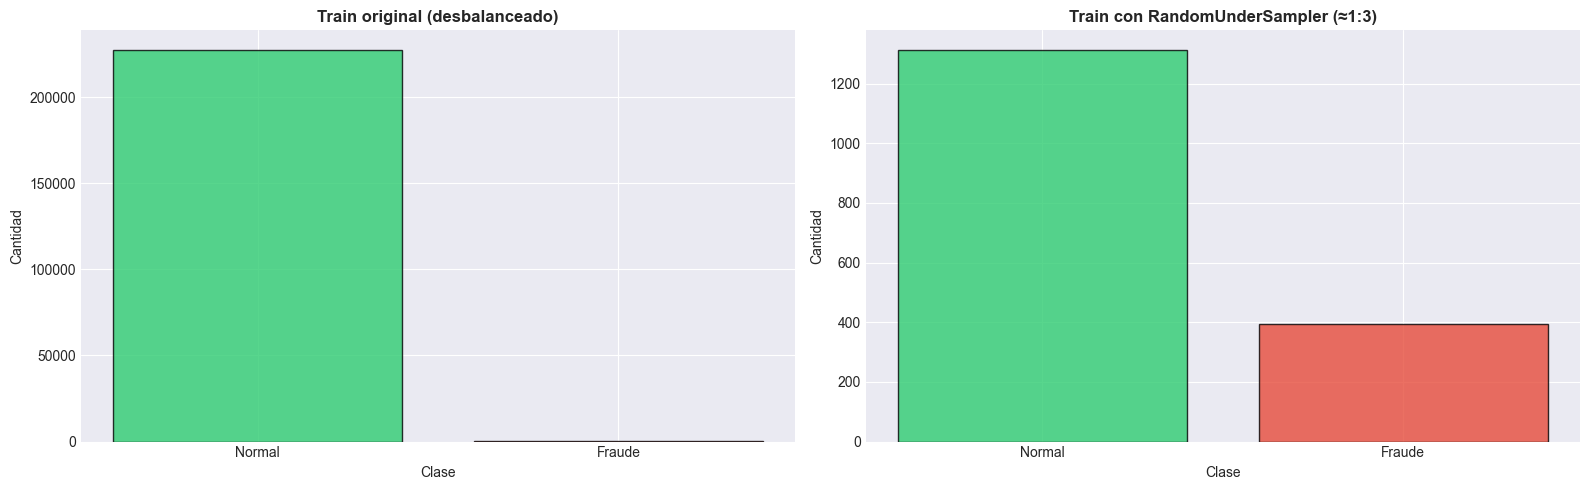

In [26]:
from imblearn.under_sampling import RandomUnderSampler

# Ajustar y transformar solo el conjunto de entrenamiento con Undersampling
# sampling_strategy=0.3 → la clase minoritaria representará un 30% del total, ratio aprox. 1:3 (fraude:normal)
rus = RandomUnderSampler(sampling_strategy=0.3, random_state=RANDOM_STATE)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

# Comparación visual de las distribuciones (train)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Original
axes[0].bar(["Normal", "Fraude"], [ (y_train == 0).sum(), (y_train == 1).sum() ],
            color=["#2ecc71", "#e74c3c"], alpha=0.8, edgecolor="black")
axes[0].set_title("Train original (desbalanceado)", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Clase")

# Undersampling (ahora ratio 1:3 aprox.)
axes[1].bar(["Normal", "Fraude"], [ (y_train_under == 0).sum(), (y_train_under == 1).sum() ],
            color=["#2ecc71", "#e74c3c"], alpha=0.8, edgecolor="black")
axes[1].set_title("Train con RandomUnderSampler (≈1:3)", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Clase")

plt.tight_layout()
plt.show()


### Comparar resultados con y sin balanceo

Entreno una Regresión Logística (como modelo baseline) sobre cada variante de train (sin balanceo y undersampling). Evaluamos sobre el conjunto de test

In [27]:
# Comparación con y sin balanceo: mismo modelo, mismo test
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# Configuración del modelo (reproducible)
from sklearn.model_selection import GridSearchCV

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"],
    "class_weight": ["balanced"],  # Mantenemos el ajuste de pesos por desbalanceo
    "max_iter": [1000],
    "random_state": [RANDOM_STATE],
}

# Usar GridSearchCV para maximizar el average_precision (AUPR)
opt_clf = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid,
    scoring="average_precision",
    cv=3,
    n_jobs=-1,
    verbose=0
)
opt_clf.fit(X_train, y_train)
best_params = opt_clf.best_params_

model_kw = dict(
    max_iter=best_params.get("max_iter", 1000),
    random_state=best_params.get("random_state", RANDOM_STATE),
    class_weight=best_params.get("class_weight", "balanced"),
    C=best_params.get("C", 1.0),
    solver=best_params.get("solver", "lbfgs")
)

# Variantes de train
trains = [
    ("Sin balanceo", X_train, y_train),
    ("Undersampling", X_train_under, y_train_under)
]

resultados = []

from sklearn.metrics import average_precision_score, precision_score, confusion_matrix

matrices_confusion = {}

for nombre, X_tr, y_tr in trains:
    clf = LogisticRegression(**model_kw).fit(X_tr, y_tr)
    y_pred = clf.predict(X_test)
    y_scores = clf.predict_proba(X_test)[:, 1]
    resultados.append({
        "Estrategia": nombre,
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),  # ¿Cuánto fraude atrapé?
        "AUPR": average_precision_score(y_test, y_scores),         # Rendimiento global sobre la clase fraude
    })
    matrices_confusion[nombre] = confusion_matrix(y_test, y_pred)

df_resultados = pd.DataFrame(resultados)
print("=" * 60)
print("Comparación (Precision, Recall y AUPR): con y sin balanceo (mismo test)")
print("=" * 60)
print(df_resultados.to_string(index=False))

print("\nMatriz de confusión para cada estrategia:\n")
for nombre, matriz in matrices_confusion.items():
    print(f"\n--- {nombre} ---")
    print(matriz)
    print("Posiciones de la matriz (sklearn):\n"
          " [[TN, FP]\n"
          "  [FN, TP]]")
    print("Donde:\n"
          "  TN = Verdaderos Negativos (matriz[0,0])\n"
          "  FP = Falsos Positivos (matriz[0,1])\n"
          "  FN = Falsos Negativos (matriz[1,0])\n"
          "  TP = Verdaderos Positivos (matriz[1,1])")

Comparación (Precision, Recall y AUPR): con y sin balanceo (mismo test)
   Estrategia  Precision   Recall     AUPR
 Sin balanceo   0.060201 0.918367 0.711455
Undersampling   0.045432 0.918367 0.714890

Matriz de confusión para cada estrategia:


--- Sin balanceo ---
[[55459  1405]
 [    8    90]]
Posiciones de la matriz (sklearn):
 [[TN, FP]
  [FN, TP]]
Donde:
  TN = Verdaderos Negativos (matriz[0,0])
  FP = Falsos Positivos (matriz[0,1])
  FN = Falsos Negativos (matriz[1,0])
  TP = Verdaderos Positivos (matriz[1,1])

--- Undersampling ---
[[54973  1891]
 [    8    90]]
Posiciones de la matriz (sklearn):
 [[TN, FP]
  [FN, TP]]
Donde:
  TN = Verdaderos Negativos (matriz[0,0])
  FP = Falsos Positivos (matriz[0,1])
  FN = Falsos Negativos (matriz[1,0])
  TP = Verdaderos Positivos (matriz[1,1])


## Fase 3: Modelado - Random Forest, XGBoost, Isolation Forest

Se entrenan tres modelos mas: Random Forest, XGBoost y  LightGBM.

### Random Forest
- No se usa X_train_smote / y_train_smote porque los modelos tardan mas de 4 horas en ejecutarse (el conjunto SMOTE es mucho más grande).
- Se entrena con el conjunto balanceado por undersampling y el conjuto original


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', {0: 1, 1: 0.7}],
}

grid_rf = GridSearchCV(
    rf_base, param_grid_rf, cv=3, scoring='f1', n_jobs=-1, verbose=1
)
grid_rf.fit(X_train_under, y_train_under)
print("Mejores hiperparámetros (Random Forest):", grid_rf.best_params_)
print("Mejor F1(validación):", round(grid_rf.best_score_, 4))

rf_best = grid_rf.best_estimator_
umbral = 0.85  # probé con 0.7, 0.75, 0.8 y 0.85. 0.85 obtuvo el mayor f1 score (prioriza tanto el recall como la precision)

# Primero calcula los scores, luego predice con el umbral
y_scores_rf = rf_best.predict_proba(X_test)[:, 1]
y_pred_rf = (y_scores_rf >= umbral).astype(int)

print("\nMétricas en test (Random Forest):")
print("  Precision:", round(precision_score(y_test, y_pred_rf, zero_division=0), 4))
print("  Recall:   ", round(recall_score(y_test, y_pred_rf, zero_division=0), 4))
print("  F1:       ", round(f1_score(y_test, y_pred_rf, zero_division=0), 4))
print("  ROC-AUC:  ", round(roc_auc_score(y_test, y_scores_rf), 4))
print("  AUPR:     ", round(average_precision_score(y_test, y_scores_rf), 4))
print("\nMatriz de confusión:")
cm = confusion_matrix(y_test, y_pred_rf)
print(cm)
print("Matriz de confusión (formato):")
print("          Predicho")
print("         0        1")
print(f"Real 0:  TN={cm[0,0]}   FP={cm[0,1]}")
print(f"Real 1:  FN={cm[1,0]}   TP={cm[1,1]}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Mejores hiperparámetros (Random Forest): {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
Mejor F1(validación): 0.9236

Métricas en test (Random Forest):
  Precision: 0.7094
  Recall:    0.8469
  F1:        0.7721
  ROC-AUC:   0.9755
  AUPR:      0.6702

Matriz de confusión:
[[56830    34]
 [   15    83]]
Matriz de confusión (formato):
          Predicho
         0        1
Real 0:  TN=56830   FP=34
Real 1:  FN=15   TP=83


### XGBoost

- Algoritmo potente para datos desbalanceados.
- **scale_pos_weight**: peso de la clase positiva (fraude). Se usa  `sum(negativos) / sum(positivos)` para compensar el desbalance.

**Por qué se elige este modelo como el mejor**

Como estamos en un contexto de **dataset desbalanceado**, uso el **AUPR** (Average Precision / área bajo la curva Precision-Recall) como métrica principal para elegir y comparar modelos. El **ROC-AUC** puede dar resultados muy altos y engañosos en este escenario porque tiene en cuenta los verdaderos negativos (TN): al haber tantísimos TN, un modelo que prediga casi todo como "normal" puede seguir teniendo un ROC-AUC alto aunque falle en detectar fraudes. El AUPR, en cambio, se centra en la clase positiva (fraude) y no se infla por la mayoría negativa, por lo que refleja mejor la capacidad del modelo para detectar fraudes.

Además del AUPR, se tienen en cuenta el **Recall** (cuántos fraudes se detectan) y **Precision** (cuántas alertas son realmente fraude).
 Este XGBoost optimizado con RandomizedSearchCV (entrenado sobre el train desbalanceado con `scale_pos_weight`) obtiene un buen balance en estas métricas en test y por eso se toma como mejor modelo.

In [29]:
# xgboost optimizado

try:
    import xgboost as xgb
except ImportError:
    %pip install xgboost
    import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# scale_pos_weight = número de negativos / número de positivos (en train)
scale_pos = (y_train == 0).sum() / max((y_train == 1).sum(), 1)

## mejores hiperparámetros: {'subsample': 0.7, 'scale_pos_weight': np.float64(577.2868020304569), 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.9}

param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5, 1],
    'reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
    'reg_lambda': [0.1, 0.5, 1, 5, 10, 15],
    'scale_pos_weight': [scale_pos, scale_pos * 0.8, scale_pos * 1.2],
}

clf = xgb.XGBClassifier(
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    tree_method="hist",
    eval_metric='logloss',
    n_jobs=-1,
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
random_search = RandomizedSearchCV(
    clf,
    param_distributions,
    n_iter=30,
    scoring='average_precision',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
)

random_search.fit(X_train, y_train)
model_xgb = random_search.best_estimator_

y_pred_xgb = model_xgb.predict(X_test)
y_scores_xgb = model_xgb.predict_proba(X_test)[:, 1]

print("Mejores hiperparámetros XGBoost:", random_search.best_params_)
print("scale_pos_weight usado:", round(model_xgb.get_params().get('scale_pos_weight', scale_pos), 2))
print("\nMétricas en test (XGBoost Optimizado):")
print("  Precision:", round(precision_score(y_test, y_pred_xgb, zero_division=0), 4))
print("  Recall:   ", round(recall_score(y_test, y_pred_xgb, zero_division=0), 4))
print("  F1:       ", round(f1_score(y_test, y_pred_xgb, zero_division=0), 4))
print("  ROC-AUC:  ", round(roc_auc_score(y_test, y_scores_xgb), 4))
print("  AUPR:     ", round(average_precision_score(y_test, y_scores_xgb), 4))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_xgb))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Mejores hiperparámetros XGBoost: {'subsample': 0.7, 'scale_pos_weight': np.float64(577.2868020304569), 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.9}
scale_pos_weight usado: 577.29

Métricas en test (XGBoost Optimizado):
  Precision: 0.8901
  Recall:    0.8265
  F1:        0.8571
  ROC-AUC:   0.9752
  AUPR:      0.8754

Matriz de confusión:
[[56854    10]
 [   17    81]]


In [30]:
# =============================================================================
# Exportar modelo y preprocesador para producción
# =============================================================================
from scripts.export_model import export_model

# model_xgb viene de la celda de entrenamiento XGBoost
# preprocessor viene de la celda 22 (cargado desde models/v1/preprocessor.joblib)
# X_test e y_test ya están preprocesados correctamente (celda 22)

export_model(
    model=model_xgb,
    preprocessor=preprocessor,
    version="v1",
    X_test=X_test,
    y_test=y_test,
    threshold=0.5,
)

print("\n✓ Modelo exportado en models/v1/")
print("  El preprocesador y el modelo son coherentes (fit solo en train)")

Exportado en C:\Agus\Deteccion de fraude\models\v1: model.joblib, preprocessor.joblib, metadata.json
Métricas en test: {'accuracy': 0.9995259997893332, 'precision': 0.8901098901098901, 'recall': 0.826530612244898, 'f1': 0.8571428571428571, 'roc_auc': 0.9751584159268659, 'aupr': 0.8754399167400079}

✓ Modelo exportado en models/v1/
  El preprocesador y el modelo son coherentes (fit solo en train)


In [ ]:
try:
    import xgboost as xgb
except ImportError:
    %pip install xgboost
    import xgboost as xgb

# Optimización de hiperparámetros para XGBoost con RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1, 2, 5],
    'scale_pos_weight': [np.float64(577.2868020304569), 
                         np.float64(577.2868020304569 * 0.8), 
                         np.float64(577.2868020304569 * 1.2)]
}

xgb_clf = xgb.XGBClassifier(
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    tree_method="hist",
    eval_metric='logloss',
    n_jobs=-1,
)

# Usar under-sampled training set para validación robusta (estratificada)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

## mejores hiperparámetros:{'subsample': 0.9, 'scale_pos_weight': np.float64(461.82944162436553), 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}
random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='average_precision',
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

random_search.fit(X_train_under, y_train_under)
xgb_best_params = random_search.best_params_
print("Mejores hiperparámetros optimizados XGBoost:", xgb_best_params)

model_xgb = xgb.XGBClassifier(**xgb_best_params)
model_xgb.fit(X_train_under, y_train_under)

y_pred_xgb = model_xgb.predict(X_test)
y_scores_xgb = model_xgb.predict_proba(X_test)[:, 1]

print("Hiperparámetros XGBoost usados:", xgb_best_params)
print("scale_pos_weight usado:", round(xgb_best_params['scale_pos_weight'], 2))
print("\nMétricas en test (XGBoost entrenado con under-sampling):")
print("  Precision:", round(precision_score(y_test, y_pred_xgb, zero_division=0), 4))
print("  Recall:   ", round(recall_score(y_test, y_pred_xgb, zero_division=0), 4))
print("  F1:       ", round(f1_score(y_test, y_pred_xgb, zero_division=0), 4))
print("  ROC-AUC:  ", round(roc_auc_score(y_test, y_scores_xgb), 4))
print("  AUPR:     ", round(average_precision_score(y_test, y_scores_xgb), 4))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_xgb))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Mejores hiperparámetros optimizados XGBoost: {'subsample': 0.9, 'scale_pos_weight': np.float64(461.82944162436553), 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}
Hiperparámetros XGBoost usados: {'subsample': 0.9, 'scale_pos_weight': np.float64(461.82944162436553), 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}
scale_pos_weight usado: 461.83

Métricas en test (XGBoost entrenado con under-sampling):
  Precision: 0.0411
  Recall:    0.9184
  F1:        0.0787
  ROC-AUC:   0.9795
  AUPR:      0.7257

Matriz de confusión:
[[54766  2098]
 [    8    90]]


### LightGBM

Gradient boosting alternativo a XGBoost; suele ser rápido. Se prueba con **X_train / y_train** (desbalanceado, usando scale_pos_weight) y con **X_train_under / y_train_under** (balanceado).

In [ ]:
# LightGBM con X_train, y_train (desbalanceado) - optimización de hiperparámetros para AUPR
try:
    import lightgbm as lgb
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'lightgbm'])
    import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV

scale_pos_lgb = (y_train == 0).sum() / max((y_train == 1).sum(), 1)

# Definición del espacio de búsqueda de hiperparámetros
param_dist_lgb = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [4, 6, 8, 10, -1],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'num_leaves': [7, 15, 31, 63, 127],
    'min_child_samples': [5, 10, 20, 40, 60],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'scale_pos_weight': [scale_pos_lgb, scale_pos_lgb * 0.8, scale_pos_lgb * 1.2],
}

lgb_estimator = lgb.LGBMClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1,
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

random_search_lgb = RandomizedSearchCV(
    lgb_estimator,
    param_distributions=param_dist_lgb,
    n_iter=30,
    scoring='average_precision',
    cv=cv,
    random_state=RANDOM_STATE,
    verbose=1,
    n_jobs=-1,
)

random_search_lgb.fit(X_train, y_train)
lgb_best_params = random_search_lgb.best_params_
print("Mejores hiperparámetros LightGBM:", lgb_best_params)

lgb_train = lgb.LGBMClassifier(**lgb_best_params, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
lgb_train.fit(X_train, y_train)

y_pred_lgb_train = lgb_train.predict(X_test)
y_scores_lgb_train = lgb_train.predict_proba(X_test)[:, 1]

print("LightGBM entrenado con X_train, y_train (mejores hiperparámetros optimizados para AUPR):")
print("  Precision:", round(precision_score(y_test, y_pred_lgb_train, zero_division=0), 4))
print("  Recall:   ", round(recall_score(y_test, y_pred_lgb_train, zero_division=0), 4))
print("  F1:       ", round(f1_score(y_test, y_pred_lgb_train, zero_division=0), 4))
print("  ROC-AUC:  ", round(roc_auc_score(y_test, y_scores_lgb_train), 4))
print("  AUPR:     ", round(average_precision_score(y_test, y_scores_lgb_train), 4))
print("Matriz de confusión:", confusion_matrix(y_test, y_pred_lgb_train).tolist())

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Mejores hiperparámetros LightGBM: {'subsample': 0.6, 'scale_pos_weight': np.float64(692.7441624365482), 'reg_lambda': 1.0, 'reg_alpha': 0.5, 'num_leaves': 63, 'n_estimators': 300, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.03, 'colsample_bytree': 0.6}
LightGBM entrenado con X_train, y_train (mejores hiperparámetros optimizados para AUPR):
  Precision: 0.8485
  Recall:    0.8571
  F1:        0.8528
  ROC-AUC:   0.9427
  AUPR:      0.8563
Matriz de confusión: [[56849, 15], [14, 84]]


In [ ]:
# LightGBM con X_train_under, y_train_under (balanceado)
# Optimizamos los hiperparámetros del LightGBM usando RandomizedSearchCV para mejorar el AUPR con underampling

## mejores hiperparámetros: {'subsample': 0.6, 'scale_pos_weight': 1.2, 'reg_lambda': 0, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
param_dist_lgb_under = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [4, 6, 8, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'scale_pos_weight': [1.0, 0.8, 1.2],  # para under, el peso no debería ser tan alto
}

lgb_estimator_under = lgb.LGBMClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1,
)

cv_under = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

random_search_lgb_under = RandomizedSearchCV(
    lgb_estimator_under,
    param_distributions=param_dist_lgb_under,
    n_iter=25,
    scoring='average_precision',
    cv=cv_under,
    random_state=RANDOM_STATE,
    verbose=1,
    n_jobs=-1,
)

random_search_lgb_under.fit(X_train_under, y_train_under)
lgb_under_best_params = random_search_lgb_under.best_params_
print("Mejores hiperparámetros LightGBM (under):", lgb_under_best_params)

lgb_under = lgb.LGBMClassifier(**lgb_under_best_params, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
lgb_under.fit(X_train_under, y_train_under)

y_pred_lgb_under = lgb_under.predict(X_test)
y_scores_lgb_under = lgb_under.predict_proba(X_test)[:, 1]

print("LightGBM entrenado con X_train_under, y_train_under:")
print("  Precision:", round(precision_score(y_test, y_pred_lgb_under, zero_division=0), 4))
print("  Recall:   ", round(recall_score(y_test, y_pred_lgb_under, zero_division=0), 4))
print("  F1:       ", round(f1_score(y_test, y_pred_lgb_under, zero_division=0), 4))
print("  ROC-AUC:  ", round(roc_auc_score(y_test, y_scores_lgb_under), 4))
print("  AUPR:     ", round(average_precision_score(y_test, y_scores_lgb_under), 4))
print("Matriz de confusión:", confusion_matrix(y_test, y_pred_lgb_under).tolist())

NameError: name 'lgb' is not defined

## Por qué elijo el XGBoost optimizado como el mejor modelo
En un contexto de dataset desbalanceado (muy pocos fraudes), uso AUPR (Average Precision / área bajo la curva Precision-Recall) como métrica principal porque:
*ROC-AUC* puede ser engañoso: al haber muchos verdaderos negativos (TN), el modelo puede tener un AUC alto solo por clasificar bien la mayoría (clase 0), aunque falle en detectar fraudes. El AUPR se centra en la clase positiva (fraude) y no se infla por la cantidad de TN.